In [1]:
# this notebook plots the histogram: nuclei count vs smFISH detected

In [2]:
# want to see the images inline
%matplotlib inline

# imports
# general 
import os
import glob
from functools import reduce
import re
import csv as csv
# scientific 
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, datasets
from scipy.stats import norm, gamma
from scipy.optimize import curve_fit
from scipy import special

import pandas as pd

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
# function for loading one data-set
def load_data(file_path, skiprows_=0):
    data = np.loadtxt(file_path, delimiter = '\t', skiprows=skiprows_)
    # print(data.shape) 
    # handles some weird cases, e.g. when there is no data in the file
    if (len(data.shape) < 2):
        data = data[None, :]
    if (data.shape[1] == 0):
        I = np.array([0])
    else:
        I = data[:, -1]
    return I

In [4]:
# possible labels 
stain = ['DPY-23_EX', 'MDH-1', 'WDR-5.2', 'DPY-23_INT']
stage = 'E' # only embryos
comment = '' # only empty ones

In [5]:
# important indices
stain_columns = ['C0_stain', 'C1_stain', 'C2_stain', 'C3_stain', 'C4_stain']
type_columns = ['C0_type', 'C1_type', 'C2_type', 'C3_type', 'C4_type']
smfish_columns = ['#C0_smfish', '#C1_smfish', '#C2_smfish', '#C3_smfish', '#C4_smfish']
nuclei_column = ['#nuclei']
stain_prefix = np.array([['C1-', 'C2-', 'C3-', 'C4-', 'C5-']])
ext = '.csv'
filename_column = 'new filename'

In [25]:
# some folder magic 
folder = '/Volumes/MILKYKLIM/super full n2/' # folder contains z-corrected spots 
# folder = '/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-08-23-11-28-45-SEA-12-all-results-together/'

In [42]:
# read the db and parse images that we want to process
df = pd.read_csv(folder + "smFISH-database/N2-Table 1.csv", sep=',', na_values=['']);
df.head()

,Line,ID,C0_lambda,C0_stain,C0_type,C1_lambda,C1_stain,C1_type,C2_lambda,C2_stain,...,comment,date,original filename,new filename,#nuclei,#C0_smfish,#C1_smfish,#C2_smfish,#C3_smfish,#C4_smfish
0,N2,1.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,not complete,11/17/2016,2016-11-17_N2-DPY-23-001.nd2,N2_1,NaN,NaN,NaN,NaN,NaN,NaN
1,N2,2.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,dirt,11/17/2016,2016-11-17_N2-DPY-23-002.nd2,N2_2,NaN,NaN,NaN,NaN,NaN,NaN
2,N2,3.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,"dirt, not complete",11/17/2016,2016-11-17_N2-DPY-23-003.nd2,N2_3,NaN,NaN,NaN,NaN,NaN,NaN
3,N2,4.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,NaN,11/17/2016,2016-11-17_N2-DPY-23-004.nd2,N2_4,NaN,NaN,NaN,NaN,NaN,NaN
4,N2,5.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,not complete,11/17/2016,2016-11-17_N2-DPY-23-005.nd2,N2_5,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# grabbing real nuclei stage from Ella
df_ella = pd.read_csv(folder + "smFISH-database/ella_embryo_spreadsheet.csv", sep=',', na_values=['']);
df_ella.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,image,#channels,c0,c1,c2,c3,...,c2_lambda,c3_lambda,c4_lambda,original filename,new filename,DAPI channel,mask maker,crop location,stage counter,stage mean
0,0,0,0,0,N2_8_50.tif,5.0,Cy5,mCherryFISH_ANndor,GoldFISH_Andor,GFP_Andor,...,566.0,507.0,461.0,2017-10-25_N2_DPY23-ex-int_mdh1_008_(series 05...,N2_870,4,RF,NaN,NaN,NaN
1,1,1,1,1,SEA12_149_42.tif,5.0,Cy5_FISH_ANDOR,mCherry_FISH_Andor,GoldFISH_ANDOR,DAPI_ANDOR,...,570.0,0.0,0.0,2017-05-28_SEA12_dpy23_wdr52_mdh1_006_(series ...,SEA-12_277,3,L,NaN,2.0,3.0
2,2,2,2,2,SEA12_43_1.tif,3.0,Cy5_FISH_ANDOR,DAPI_ANDOR,GFP_ANDOR,NaN,...,0.0,NaN,NaN,2017-04-04_SEA12_DPY23_028_(series 001).nd2,SEA-12_144,1,L,NaN,NaN,NaN
3,3,3,3,3,N2_130_1.tif,5.0,Cy5,mCherryFISH_ANndor,GoldFISH_Andor,GFP_Andor,...,566.0,507.0,461.0,2017-10-25_N2_DPY23-ex-int_mdh1_007_08.nd2,N2_871,4,RF,310 620 383 577,1.0,1.0
4,4,4,4,4,MK4_2_18.tif,5.0,Cy5,mCherryFISH_ANndor,GoldFISH_Andor,GFP_Andor,...,566.0,507.0,461.0,2017-10-25_MK4_DPY23-ex-int_mdh1_004_(series 0...,MK4_1,4,RF,296 625 313 547,1.0,1.0


In [44]:
# field you are looking for is stage counter ''
df_ella_length = df_ella['new filename'].size
df_length = df['new filename'].size

for row in range(0, df_ella_length):
    if (not np.isnan(df_ella['stage counter'][row])):
        # print (row, df_ella['new filename'][row])
        for to_set_row in range(0, df_length):
            if (df['new filename'][to_set_row] == df_ella['new filename'][row]):
                print(df['new filename'][to_set_row], df_ella['new filename'][row])
                print(df['#nuclei'][to_set_row]) 
                df.set_value(to_set_row, '#nuclei', df_ella['stage counter'][row])
                print(df['#nuclei'][to_set_row]) 

N2_871 N2_871
nan
1.0
N2_149 N2_149
nan
1.0
N2_872 N2_872
nan
3.0
N2_873 N2_873
nan
2.0
N2_336 N2_336
nan
1.0


/Users/kkolyva/anaconda3/envs/pretty-graphs/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':


N2_81 N2_81
nan
2.0
N2_292 N2_292
nan
4.0
N2_882 N2_882
nan
4.0
N2_215 N2_215
nan
2.0
N2_145 N2_145
nan
4.0
N2_28 N2_28
nan
4.0
N2_286 N2_286
nan
3.0
N2_884 N2_884
nan
2.0
N2_885 N2_885
nan
4.0
N2_886 N2_886
nan
2.0
N2_283 N2_283
nan
2.0
N2_114 N2_114
nan
4.0
N2_85 N2_85
nan
1.0
N2_224 N2_224
nan
2.0
N2_891 N2_891
nan
4.0
N2_892 N2_892
nan
3.0
N2_64 N2_64
nan
2.0
N2_894 N2_894
nan
2.0
N2_895 N2_895
nan
4.0
N2_896 N2_896
nan
1.0
N2_193 N2_193
nan
2.0
N2_900 N2_900
nan
1.0
N2_199 N2_199
nan
4.0
N2_902 N2_902
nan
4.0
N2_903 N2_903
nan
3.0
N2_904 N2_904
nan
1.0
N2_905 N2_905
nan
4.0
N2_315 N2_315
nan
2.0
N2_906 N2_906
nan
4.0
N2_909 N2_909
nan
3.0
N2_910 N2_910
nan
3.0
N2_262 N2_262
nan
2.0
N2_912 N2_912
nan
2.0
N2_201 N2_201
nan
2.0
N2_915 N2_915
nan
2.0
N2_317 N2_317
nan
1.0
N2_916 N2_916
nan
2.0
N2_918 N2_918
nan
3.0
N2_919 N2_919
nan
4.0
N2_921 N2_921
nan
1.0
N2_43 N2_43
nan
4.0
N2_922 N2_922
nan
1.0
N2_125 N2_125
nan
4.0
N2_924 N2_924
nan
4.0
N2_103 N2_103
nan
2.0
N2_249 N2_249
nan
2.

N2_526 N2_526
17.0
1.0
N2_527 N2_527
150.0
4.0
N2_528 N2_528
200.0
4.0
N2_529 N2_529
8.0
1.0
N2_530 N2_530
200.0
4.0
N2_531 N2_531
30.0
2.0
N2_532 N2_532
23.0
2.0
N2_535 N2_535
5.0
1.0
N2_536 N2_536
2.0
1.0
N2_537 N2_537
9.0
1.0
N2_538 N2_538
300.0
4.0
N2_539 N2_539
3.0
1.0
N2_540 N2_540
80.0
2.0
N2_541 N2_541
14.0
1.0
N2_542 N2_542
200.0
4.0
N2_543 N2_543
16.0
1.0
N2_544 N2_544
33.0
1.0
N2_545 N2_545
350.0
4.0
N2_546 N2_546
60.0
3.0
N2_547 N2_547
50.0
2.0
N2_549 N2_549
22.0
1.0
N2_550 N2_550
10.0
1.0
N2_551 N2_551
40.0
2.0
N2_552 N2_552
300.0
4.0
N2_553 N2_553
250.0
4.0
N2_554 N2_554
7.0
1.0
N2_555 N2_555
5.0
1.0
N2_556 N2_556
8.0
1.0
N2_557 N2_557
13.0
1.0
N2_558 N2_558
35.0
2.0
N2_559 N2_559
50.0
2.0
N2_560 N2_560
300.0
4.0
N2_561 N2_561
200.0
2.0
N2_562 N2_562
2.0
1.0
N2_563 N2_563
4.0
1.0
N2_564 N2_564
10.0
1.0
N2_565 N2_565
250.0
2.0
N2_566 N2_566
200.0
4.0
N2_567 N2_567
3.0
1.0
N2_568 N2_568
15.0
1.0
N2_569 N2_569
4.0
1.0
N2_570 N2_570
5.0
1.0
N2_571 N2_571
8.0
1.0
N2_572 N2_572

N2_304 N2_304
nan
4.0
N2_310 N2_310
nan
1.0
N2_312 N2_312
nan
1.0
N2_319 N2_319
nan
2.0
N2_332 N2_332
nan
2.0
N2_333 N2_333
nan
1.0


In [45]:
# df.set_value(0, 'C0_stain', 'LOLLY').head()
# df.set_value(0, smfish_columns[1], 666).head()
# df[df['#nuclei'] == -1]['#nuclei'].senp.NaN
df['#nuclei'] = df['#nuclei'].apply(lambda x: np.NaN if x == -1 else x)
df.head()

,Line,ID,C0_lambda,C0_stain,C0_type,C1_lambda,C1_stain,C1_type,C2_lambda,C2_stain,...,comment,date,original filename,new filename,#nuclei,#C0_smfish,#C1_smfish,#C2_smfish,#C3_smfish,#C4_smfish
0,N2,1.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,not complete,11/17/2016,2016-11-17_N2-DPY-23-001.nd2,N2_1,NaN,NaN,NaN,NaN,NaN,NaN
1,N2,2.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,dirt,11/17/2016,2016-11-17_N2-DPY-23-002.nd2,N2_2,NaN,NaN,NaN,NaN,NaN,NaN
2,N2,3.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,"dirt, not complete",11/17/2016,2016-11-17_N2-DPY-23-003.nd2,N2_3,NaN,NaN,NaN,NaN,NaN,NaN
3,N2,4.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,NaN,11/17/2016,2016-11-17_N2-DPY-23-004.nd2,N2_4,1.0,NaN,NaN,NaN,NaN,NaN
4,N2,5.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,not complete,11/17/2016,2016-11-17_N2-DPY-23-005.nd2,N2_5,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
def create_title(path, name_id=-1):
    # get the name of the initial image
    image_name = path.split("/")[name_id] # was 8
    # print(path.split("/"))
    # create the full title 
    title = image_name[:-4]
    return title
# create_title("/Users/kkolyva/Desktop/n2/N2-results/all/C1-N2_9.csv")

In [74]:
labels = ['MDH-1'] # ['DPY-23_EX', 'WDR-5.2', 'MDH-1']
color = '#00A79D' # '#BA5536'
if labels[0] == 'MDH-1':
    color = '#FF9300' # "#693D3D"

In [75]:
# this is general
# filter to have only *good* and *embryo* files
good_indices = np.logical_and((df['stage'] == stage).tolist() , (df['comment'].isnull()).tolist())
good_indices.shape[0]
print(np.sum(good_indices == True))

596


In [52]:
# choose necessary stains
# dpy23
dataset1 = []
df_good = (df[type_columns].astype(np.object) == stain[0]).loc[good_indices, :]
row, col = np.where(df_good)
n_samples = df.shape[0]
new_prefix = np.repeat(stain_prefix, n_samples, axis=0)[row, col]
new_filename = df[filename_column].loc[good_indices].values[row]
dataset1 = ["{}{}".format(a_, b_) for a_, b_ in zip(new_prefix, new_filename)]

# new 
dataset1_nuclei = df[nuclei_column].loc[good_indices].values[row]
# the detection of the smfish spots is a bit tricky because you have to find the correct channel again
dataset1_smfish = df[smfish_columns[0]].loc[good_indices].values[row]

In [76]:
# choose necessary stains
# mdh1
dataset2 = []
df_good = (df[type_columns].astype(np.object) == stain[1]).loc[good_indices, :]
row, col = np.where(df_good)
n_samples = df.shape[0]
new_prefix = np.repeat(stain_prefix, n_samples, axis=0)[row, col]
new_filename = df[filename_column].loc[good_indices].values[row]
dataset2 = ["{}{}".format(a_, b_) for a_, b_ in zip(new_prefix, new_filename)]
print([row, col])

[array([ 70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 142, 143, 195, 196, 197, 198,
       199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211,
       212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224,
       225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237,
       238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250,
       251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263,
       264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276,
       277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289,
       290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 3

In [18]:
# choose necessary stains
# 'WDR-5.2'
dataset3 = []
df_good = (df[type_columns].astype(np.object) == stain[2]).loc[good_indices, :]
row, col = np.where(df_good)
n_samples = df.shape[0]
new_prefix = np.repeat(stain_prefix, n_samples, axis=0)[row, col]
new_filename = df[filename_column].loc[good_indices].values[row]
dataset3 = ["{}{}".format(a_, b_) for a_, b_ in zip(new_prefix, new_filename)]

print(df_good.iloc[row].index)

Int64Index([148, 149, 150, 151, 159, 165, 167, 176, 177, 181, 188, 190, 192,
            193, 196, 197, 199, 207, 208, 209, 210, 211, 212, 215, 216, 217,
            220, 221, 224, 226, 227, 229, 230, 237, 238, 239, 240, 244, 245,
            246, 248, 249, 254, 256, 257, 258, 262, 266, 273, 276, 277, 281,
            282, 285, 286, 291],
           dtype='int64')


In [35]:
print(df_good[:])

     C0_type  C1_type  C2_type  C3_type  C4_type
0       True    False    False    False    False
8       True    False    False    False    False
26      True    False    False    False    False
39      True    False    False    False    False
41      True    False    False    False    False
42      True    False    False    False    False
49      True    False    False    False    False
51      True    False    False    False    False
66      True    False    False    False    False
73      True    False    False    False    False
76      True    False    False    False    False
82      True    False    False    False    False
83      True    False    False    False    False
86      True    False    False    False    False
89      True    False    False    False    False
90      True    False    False    False    False
93      True    False    False    False    False
100     True    False    False    False    False
113     True    False    False    False    False
114    False    Fals

In [77]:
dataset = dataset2
folder + 'csv-2/' + dataset[0] + '.csv'

'/Volumes/MILKYKLIM/super full n2/csv-2/C2-N2_159.csv'

In [78]:
# run over all images n_timeframes times to plot the correct images:
for idx in range(0, len(dataset)):
    full_filepath = folder + 'csv-2/' +  dataset[idx] + '.csv';
    if(not os.path.exists(full_filepath)):
        # print("doesn't exist")
        continue

    # use try catch because some files might be empty or broken
    try: 
        # print(dataset[idx])
        # load the data and scale it accordingly
        I = load_data(full_filepath)
        I_res = I

        # df_good.iloc[row].index[idx]    
        new_row = df_good.iloc[row].index[idx]
        new_col = smfish_columns[col[idx]]
        total_smfish = len(I)
        
        # print(total_smfish, new_row, new_col)
        
        df.set_value(new_row, new_col, total_smfish)
        
    except(RuntimeError, TypeError, ValueError, StopIteration):
        print("There was an exception but we\'ll fix it for you")

df.ix[0:10]

/Users/kkolyva/anaconda3/envs/pretty-graphs/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/kkolyva/anaconda3/envs/pretty-graphs/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: loadtxt: Empty input file: "/Volumes/MILKYKLIM/super full n2/csv-2/C2-N2_331.csv"
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/kkolyva/anaconda3/envs/pretty-graphs/lib/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


,Line,ID,C0_lambda,C0_stain,C0_type,C1_lambda,C1_stain,C1_type,C2_lambda,C2_stain,...,comment,date,original filename,new filename,#nuclei,#C0_smfish,#C1_smfish,#C2_smfish,#C3_smfish,#C4_smfish
0,N2,1.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,not complete,11/17/2016,2016-11-17_N2-DPY-23-001.nd2,N2_1,NaN,NaN,NaN,NaN,NaN,NaN
1,N2,2.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,dirt,11/17/2016,2016-11-17_N2-DPY-23-002.nd2,N2_2,NaN,NaN,NaN,NaN,NaN,NaN
2,N2,3.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,"dirt, not complete",11/17/2016,2016-11-17_N2-DPY-23-003.nd2,N2_3,NaN,NaN,NaN,NaN,NaN,NaN
3,N2,4.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,NaN,11/17/2016,2016-11-17_N2-DPY-23-004.nd2,N2_4,1.0,NaN,NaN,NaN,NaN,NaN
4,N2,5.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,not complete,11/17/2016,2016-11-17_N2-DPY-23-005.nd2,N2_5,NaN,NaN,NaN,NaN,NaN,NaN
5,N2,6.0,670.0,FISH,ELT-2_EX,405.0,NUCLEAR,DAPI,NaN,NaN,...,phenotype,2/8/2017,2017-02-08_N2-elt-80_001.nd2,N2_6,NaN,NaN,NaN,NaN,NaN,NaN
6,N2,7.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,drift,2/23/2017,2017-02-23_N2-DPY23-001.nd2,N2_7,NaN,NaN,NaN,NaN,NaN,NaN
7,N2,8.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,saturated,2/23/2017,2017-02-23_N2-DPY23-002.nd2,N2_8,NaN,NaN,NaN,NaN,NaN,NaN
8,N2,9.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,NaN,2/23/2017,2017-02-23_N2-DPY23-003.nd2,N2_9,NaN,NaN,NaN,NaN,NaN,NaN
9,N2,10.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,dirt,2/24/2017,2017-02-24_N2-DPY23-001.nd2,N2_10,4.0,NaN,NaN,NaN,NaN,NaN


In [57]:
df.iloc[:30]

,Line,ID,C0_lambda,C0_stain,C0_type,C1_lambda,C1_stain,C1_type,C2_lambda,C2_stain,...,comment,date,original filename,new filename,#nuclei,#C0_smfish,#C1_smfish,#C2_smfish,#C3_smfish,#C4_smfish
0,N2,1.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,not complete,11/17/2016,2016-11-17_N2-DPY-23-001.nd2,N2_1,NaN,NaN,NaN,NaN,NaN,NaN
1,N2,2.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,dirt,11/17/2016,2016-11-17_N2-DPY-23-002.nd2,N2_2,NaN,NaN,NaN,NaN,NaN,NaN
2,N2,3.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,"dirt, not complete",11/17/2016,2016-11-17_N2-DPY-23-003.nd2,N2_3,NaN,NaN,NaN,NaN,NaN,NaN
3,N2,4.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,NaN,11/17/2016,2016-11-17_N2-DPY-23-004.nd2,N2_4,1.0,NaN,NaN,NaN,NaN,NaN
4,N2,5.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,not complete,11/17/2016,2016-11-17_N2-DPY-23-005.nd2,N2_5,NaN,NaN,NaN,NaN,NaN,NaN
5,N2,6.0,670.0,FISH,ELT-2_EX,405.0,NUCLEAR,DAPI,NaN,NaN,...,phenotype,2/8/2017,2017-02-08_N2-elt-80_001.nd2,N2_6,NaN,NaN,NaN,NaN,NaN,NaN
6,N2,7.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,drift,2/23/2017,2017-02-23_N2-DPY23-001.nd2,N2_7,NaN,NaN,NaN,NaN,NaN,NaN
7,N2,8.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,saturated,2/23/2017,2017-02-23_N2-DPY23-002.nd2,N2_8,NaN,NaN,NaN,NaN,NaN,NaN
8,N2,9.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,NaN,2/23/2017,2017-02-23_N2-DPY23-003.nd2,N2_9,NaN,NaN,NaN,NaN,NaN,NaN
9,N2,10.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,dirt,2/24/2017,2017-02-24_N2-DPY23-001.nd2,N2_10,4.0,NaN,NaN,NaN,NaN,NaN


In [58]:
updated_fullpath = folder + "smFISH-database/N2-Table 1 updated.csv"
df.to_csv(updated_fullpath, index=False)

In [59]:
df[nuclei_column] == 1
df[stain_columns[0]]

0      FISH
1      FISH
2      FISH
3      FISH
4      FISH
5      FISH
6      FISH
7      FISH
8      FISH
9      FISH
10     FISH
11     FISH
12     FISH
13     FISH
14     FISH
15     FISH
16     FISH
17     FISH
18     FISH
19     FISH
20     FISH
21     FISH
22     FISH
23     FISH
24     FISH
25     FISH
26     FISH
27     FISH
28     FISH
29     FISH
       ... 
910     NaN
911     NaN
912     NaN
913     NaN
914     NaN
915     NaN
916     NaN
917     NaN
918     NaN
919     NaN
920     NaN
921     NaN
922     NaN
923     NaN
924     NaN
925     NaN
926     NaN
927     NaN
928     NaN
929     NaN
930     NaN
931     NaN
932     NaN
933     NaN
934     NaN
935     NaN
936     NaN
937     NaN
938     NaN
939     NaN
Name: C0_stain, Length: 940, dtype: object

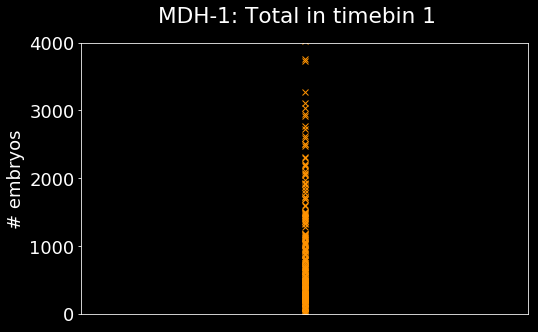

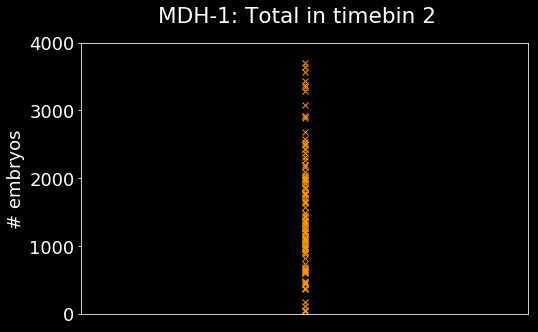

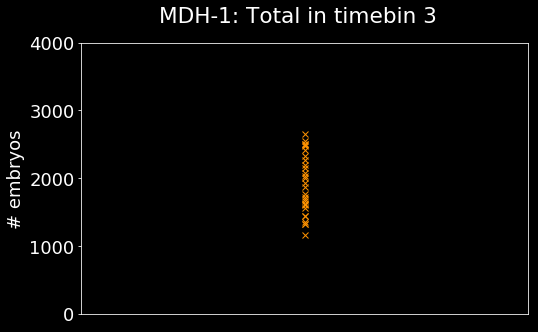

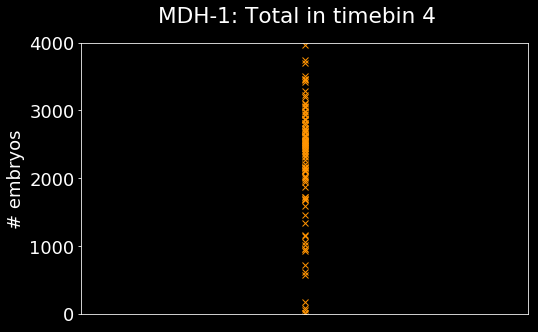

DOGE!


In [79]:
# IMPORTANT: KEEP THIS ONE! YOU WILL NEED IT LATER

# grab # nuclei 
# grab # of smfish
num_rows = df.shape[0]
num_timeframes = 4

x_pos = 10;

for t in range (0, num_timeframes):    
    result_set = []
    for j in range(0, num_rows):
        try: 
            # grab: 
            # - current timeframe
            # - correct gene 
            if (not np.isnan(df['#nuclei'][j])):
                if (df['#nuclei'][j] == (t + 1)):
                    for k in range(0, len(type_columns)): # over experiments
                        if (df[type_columns[k]][j] == stain[1]): 
                            if (not np.isnan(df[smfish_columns[k]][j])):
                                # print('GOOD!')
                                result_set.append(df[smfish_columns[k]][j])
                                # add picture to the image;
                                # print(stain[1], t + 1, df[smfish_columns[k]][j])
                                
                                
                                
                                
                            break
        except(RuntimeError, TypeError, ValueError, StopIteration):
        # except(ValueError):
            print("There was an exception but we\'ll fix it for you")
    # print(result_set)
    # plot here
    
    x = np.ones(len(result_set))*x_pos # + np.random.random(len(result_set))
    
    fig = plt.figure(figsize=(8,5))
    fig.suptitle(stain[1] + ": Total in timebin " + str(t + 1))
    plt.plot(x, result_set, 'x', color=color)
    
    # TODO: remove the widefile images 
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
    
    plt.ylim([-10, 4000])

    # plt.xlabel("# spots")
    plt.ylabel("# embryos")

    # df_center = pd.DataFrame(list(result_set.items()), columns=['filename', 'total'])
    # if not os.path.exists(folder_path):
    #     os.makedirs(folder_path )
    # df_center.to_csv(folder_path + labels[0] +"-total.csv", index=False, header=True, encoding='utf-8', mode = 'w' )
    if not os.path.exists(folder + "spread/"):
        os.makedirs(folder + "spread/")
    plt.savefig(folder + "spread/" + labels[0] + "-" + str(t + 1) + "-stage-spread.pdf") 
    plt.show()

print ("DOGE!") 

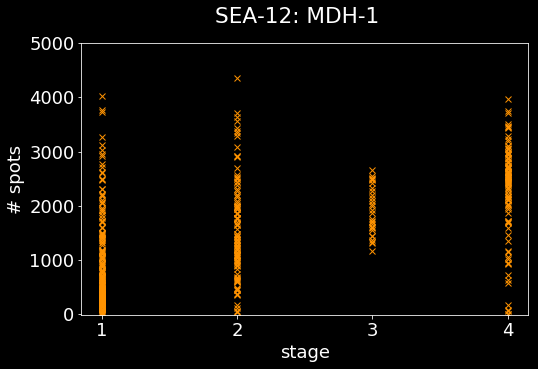

DOGE!


In [80]:
# IMPORTANT: KEEP THIS ONE! YOU WILL NEED IT LATER

# grab # nuclei 
# grab # of smfish
num_rows = df.shape[0]
num_timeframes = 4

fig = plt.figure(figsize=(8,5))
fig.suptitle("SEA-12: " + stain[1])

for t in range (0, num_timeframes):    
    result_set = []
    for j in range(0, num_rows):
        try: 
            # grab: 
            # - current timeframe
            # - correct gene 
            if (not np.isnan(df['#nuclei'][j])):
                if (df['#nuclei'][j] == (t + 1)):
                    for k in range(0, len(type_columns)): # over experiments
                        if (df[type_columns[k]][j] == stain[1]): 
                            if (not np.isnan(df[smfish_columns[k]][j])):
                                result_set.append(df[smfish_columns[k]][j])
                                # add picture to the image;
                                # print(stain[1], t + 1, df[smfish_columns[k]][j])
                            break
        except(RuntimeError, TypeError, ValueError, StopIteration):
        # except(ValueError):
            print("There was an exception but we\'ll fix it for you")
    # print(result_set)
    # plot here
    
    x_pos = t + 1;
    
    x = np.ones(len(result_set))*x_pos # + np.random.random(len(result_set))
    
#     fig = plt.figure(figsize=(8,5))
#     fig.suptitle("N2: " + stain[1] + ": Total in timebin " + str(t + 1))
    plt.plot(x, result_set, 'x', color=color)
    
    # TODO: remove the widefile images 
#     plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False)
    plt.xticks([1,2,3,4])
    
    plt.ylim([-10, 5000])

    plt.xlabel("stage")
    plt.ylabel("# spots")

    # df_center = pd.DataFrame(list(result_set.items()), columns=['filename', 'total'])
    # if not os.path.exists(folder_path):
    #     os.makedirs(folder_path )
    # df_center.to_csv(folder_path + labels[0] +"-total.csv", index=False, header=True, encoding='utf-8', mode = 'w' )
if not os.path.exists(folder + "spread/"):
    os.makedirs(folder + "spread/")
plt.savefig(folder + "spread/" + labels[0] + "-" + str(t + 1) + "-stage-spread-all.pdf") 
plt.show()

print ("DOGE!") 

In [155]:
print(stain[1], labels[0])
df[type_columns[1]][300]

MDH-1 MDH-1


'MDH-1'

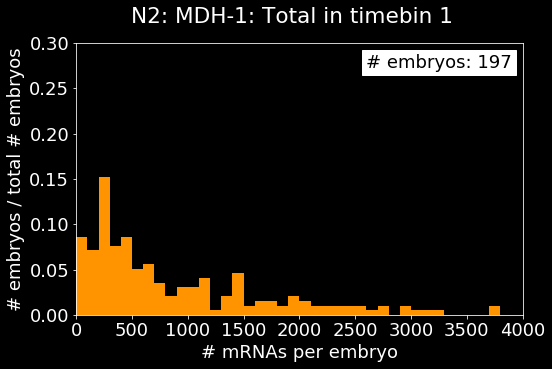

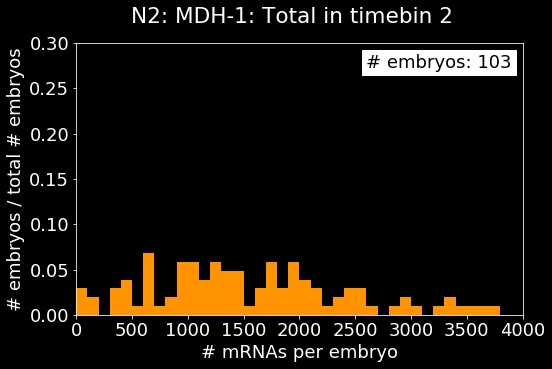

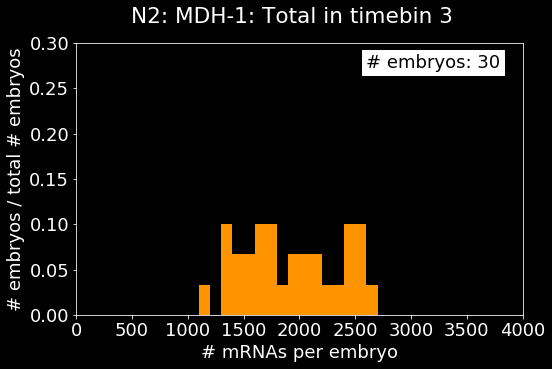

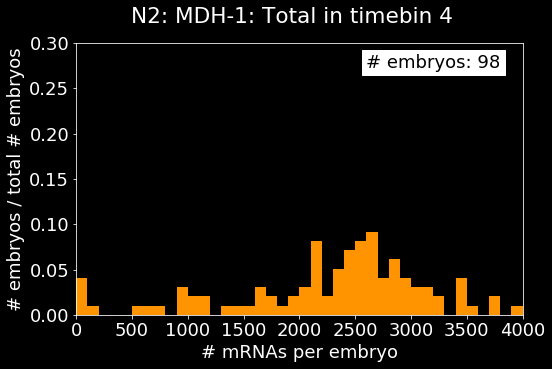

DOGE!


In [81]:
# grab # nuclei 
# grab # of smfish
num_rows = df.shape[0]
num_timeframes = 4

x_pos = 10;

plt.rcParams.update({'font.size': 18})
plt.style.use('dark_background')


for t in range (0, num_timeframes):    
    result_set = []
    for j in range(0, num_rows):
        try: 
            # grab: 
            # - current timeframe
            # - correct gene 
            if (not np.isnan(df['#nuclei'][j])):
                if (df['#nuclei'][j] == (t + 1)):
                    for k in range(0, len(type_columns)): # over experiments
                        if (df[type_columns[k]][j] == stain[1]): 
                            if (not np.isnan(df[smfish_columns[k]][j])):
                                result_set.append(df[smfish_columns[k]][j])
                                # add picture to the image;
                                # print(stain[1], t + 1, df[smfish_columns[k]][j])
                            break
        except(RuntimeError, TypeError, ValueError, StopIteration):
            print("There was an exception but we\'ll fix it for you")     
    # these are subject to change
    xmin = 0
    xmax = 4000
    
    binwidth = 100
    
    # total number of spots in all embryos per one timebin (stage)
    # normalization seems fine
    # print ("1.0 ?=", np.sum ( (result_set*binwidth) / np.sum(result_set*binwidth) ))
    # print ((result_set*binwidth) / np.sum(result_set*binwidth) )
    
    num_bins = (xmax - xmin) / binwidth + 1;
    bins = np.arange(xmin, xmax + binwidth, binwidth)
    
    xlimits = [xmin, xmax]
    ylimits = [0, 0.30]

    fig = plt.figure(figsize=(8,5))
    fig.suptitle("N2: " + stain[1] + ": Total in timebin " + str(t + 1))
    
    # plt.hist( (result_set) / np.sum(result_set), bins=bins, color=color, label=labels, normed=False)
    
    axes = plt.gca()
    axes.set_xlim(xlimits)
    axes.set_ylim(ylimits)
    
    weights = np.ones_like(result_set)/len(result_set)    
    plt.plot();
    plt.hist(result_set, bins=bins, color=color, label=labels, weights=weights) # normed=True)
     
    plt.xlabel("# mRNAs per embryo")
    plt.ylabel("# embryos / total # embryos")
    
    info_text = "# embryos: " + str(len(result_set))
    plt.text(xlimits[1]*0.65, ylimits[1]*0.91, info_text, color='black', bbox=dict(facecolor='white', alpha=1)) #, family='monospace')

#     df_center = pd.DataFrame(list(result_set.items()), columns=['filename', 'total'])
#     if not os.path.exists(folder_path):
#         os.makedirs(folder_path )
#     df_center.to_csv(folder_path + labels[0] +"-total.csv", index=False, header=True, encoding='utf-8', mode = 'w' )
    if not os.path.exists(folder + "stages/"):
         os.makedirs(folder + "stages/")
    plt.savefig(folder + "stages/" + labels[0] + "-" + str(t + 1) + "-stage-total.pdf") 

    plt.show()

print ("DOGE!") 

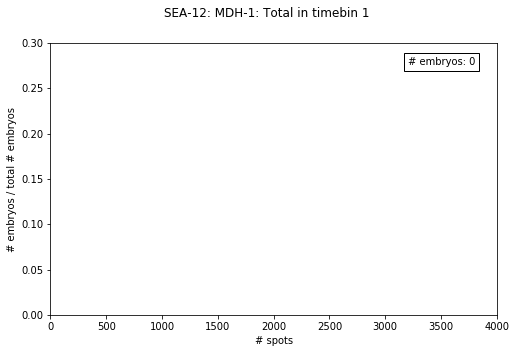

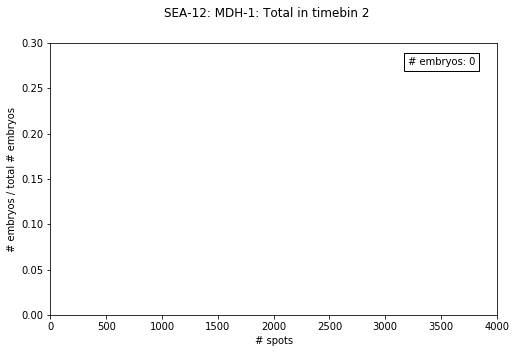

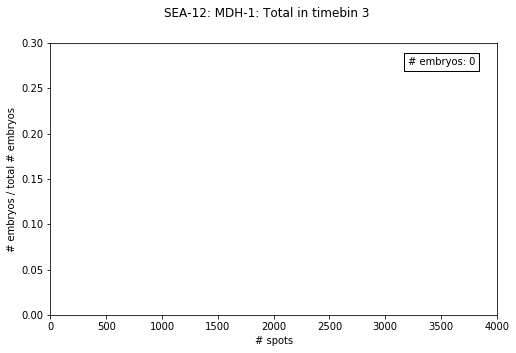

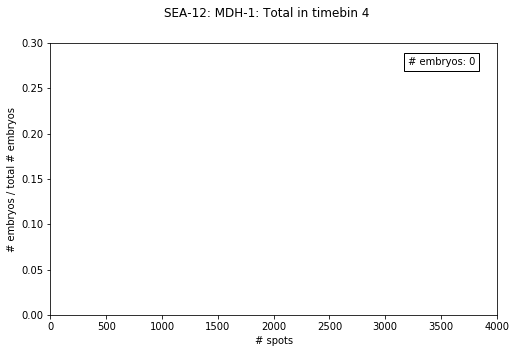

DOGE!


In [39]:
# grab # nuclei 
# grab # of smfish
num_rows = df.shape[0]
num_timeframes = 4

x_pos = 10;

for t in range (0, num_timeframes):    
    result_set = []
    for j in range(0, num_rows):
        try: 
            # grab: 
            # - current timeframe
            # - correct gene 
            if (not np.isnan(df['#nuclei'][j])):
                if (df['#nuclei'][j] == (t + 1)):
                    for k in range(0, len(type_columns)): # over experiments
                        if (df[type_columns[k]][j] == stain[1]): 
                            if (not np.isnan(df[smfish_columns[k]][j])):
                                result_set.append(df[smfish_columns[k]][j])
                                # add picture to the image;
                                # print(stain[1], t + 1, df[smfish_columns[k]][j])
                            break
        except(RuntimeError, TypeError, ValueError, StopIteration):
            print("There was an exception but we\'ll fix it for you")     
    # these are subject to change
    xmin = 0
    xmax = 4000
    
    binwidth = 100
    
    # total number of spots in all embryos per one timebin (stage)
    # normalization seems fine
    # print ("1.0 ?=", np.sum ( (result_set*binwidth) / np.sum(result_set*binwidth) ))
    # print ((result_set*binwidth) / np.sum(result_set*binwidth) )
    
    num_bins = (xmax - xmin) / binwidth + 1;
    bins = np.arange(xmin, xmax + binwidth, binwidth)
    
    xlimits = [xmin, xmax]
    ylimits = [0, 0.30]

    fig = plt.figure(figsize=(8,5))
    fig.suptitle("SEA-12: " + stain[1] + ": Total in timebin " + str(t + 1))
    
    # plt.hist( (result_set) / np.sum(result_set), bins=bins, color=color, label=labels, normed=False)
    
    axes = plt.gca()
    axes.set_xlim(xlimits)
    axes.set_ylim(ylimits)
    
    weights = np.ones_like(result_set)/len(result_set)    
    plt.plot();
    plt.hist(result_set, bins=bins, color=color, label=labels, weights=weights) # normed=True)
     
    plt.xlabel("# spots")
    plt.ylabel("# embryos / total # embryos")
    
    info_text = "# embryos: " + str(len(result_set))
    plt.text(xlimits[1]*0.8, ylimits[1]*0.92, info_text, color='black', bbox=dict(facecolor='white', alpha=1)) #, family='monospace')

#     df_center = pd.DataFrame(list(result_set.items()), columns=['filename', 'total'])
#     if not os.path.exists(folder_path):
#         os.makedirs(folder_path )
#     df_center.to_csv(folder_path + labels[0] +"-total.csv", index=False, header=True, encoding='utf-8', mode = 'w' )
    if not os.path.exists(folder + "stages/"):
         os.makedirs(folder + "stages/")
    plt.savefig(folder + "stages/" + labels[0] + "-" + str(t + 1) + "-stage-total.pdf") 

    plt.show()

print ("DOGE!") 